In [1]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl==0.15.2 triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1" huggingface_hub hf_transfer
    !pip install transformers==4.51.3
    !pip install --no-deps unsloth

In [2]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs unsloth/Qwen2.5-VL-7B-Instruct-bnb-4bit"
import torch
model, tokenizer = FastVisionModel.from_pretrained(
    "tetttssts/final",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


2025-06-03 13:20:02.485461: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748956802.654719      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748956802.706156      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.5.9: Fast Qwen2 patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.97G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/5.80k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/162M [00:00<?, ?B/s]

In [3]:
from datasets import load_dataset
dataset_id = "bicat123/testdata"
train_dataset, test_dataset = load_dataset(dataset_id, split=['train', 'test'])

README.md:   0%|          | 0.00/642 [00:00<?, ?B/s]

(…)-00000-of-00001-1a701ae290074d3d.parquet:   0%|          | 0.00/430M [00:00<?, ?B/s]

(…)-00000-of-00001-d02383259abe1f44.parquet:   0%|          | 0.00/103M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2139 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/535 [00:00<?, ? examples/s]

In [4]:
train_dataset

Dataset({
    features: ['IDDetect', 'IDTraking', 'image'],
    num_rows: 2139
})

In [5]:
test_dataset

Dataset({
    features: ['IDDetect', 'IDTraking', 'image', 'bbox2d', 'Time', 'Speed', 'classification', 'Altitude', 'Range', 'zone_name', 'geom_point'],
    num_rows: 1409
})

In [9]:
system_message = """give me the bbox2d  of the drone detected in images even infrared images in josn format and even its small 
"""

In [24]:
FastVisionModel.for_inference(model) # Enable for inference!
image = train_dataset[0]["image"]
messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": system_message }
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature =0.2, min_p = 0.1)

Here is the detected drone's information in JSON format:

```json
[
    {
        "bbox_2d": [1439, 570, 1638, 623],
        "label": "drone"
    }
]
```<|im_end|>


rgex model final1

In [21]:
import re

def extract_first_bbox(text):
    match = re.search(r'bbox2d\s*\[\s*(\d+)\s*,\s*(\d+)\s*,\s*(\d+)\s*,\s*(\d+)\s*\]', text)
    if match:
        bbox = [int(match.group(i)) for i in range(1, 5)]
        return bbox
    return None


In [25]:
import re

def extract_first_bbox(text):
    match = re.search(r'"bbox_2d"\s*:\s*\[([^\]]+)\]', text)
    if match:
        bbox_str = match.group(1)
        bbox = [int(x.strip()) for x in bbox_str.split(',')]
        return bbox
    return None


In [19]:
def infer(image):
    try:

        messages = [{
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": system_message }
            ]
        }]

        input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)

        inputs = tokenizer(
            image,
            input_text,
            add_special_tokens=False,
            return_tensors="pt"
        ).to("cuda")

        output = model.generate(
            **inputs,
            max_new_tokens=128,
            use_cache=True,
            temperature=0.2,
            min_p=0.9
        )

        decoded_output = tokenizer.decode(output[0], skip_special_tokens=True)
        return extract_first_bbox(decoded_output)

    except Exception as e:
        return f"Error during inference: {str(e)}"


In [31]:
bbox2d=[0, 0, 0, 0]

In [26]:
image = train_dataset[0]["image"]
bbox2d=infer(image)

In [27]:
bbox2d

[1439, 568, 1640, 623]

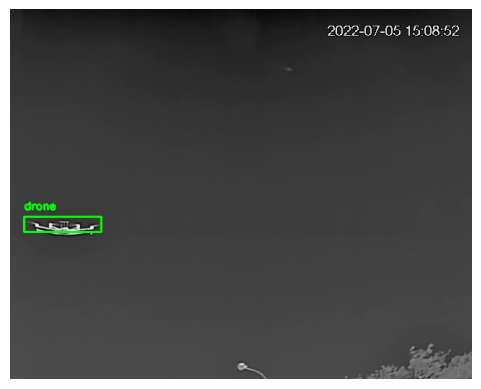

True

In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# Convert from PIL Image to NumPy array
image = train_dataset[928]["image"]
image = np.array(image)

# Convert RGB to BGR (OpenCV uses BGR)
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

# Define the bounding box and label
annotations = [
    {"bbox_2d":[19, 287, 126, 308], "label": "drone"}
]

# Draw rectangle and label
for annotation in annotations:
    x1, y1, x2, y2 = annotation["bbox_2d"]
    label = annotation["label"]

    cv2.rectangle(image, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)
    cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX,
                0.5, (0, 255, 0), 2)

# Convert BGR to RGB for display
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Show image using matplotlib
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

# Save image
cv2.imwrite('output.jpg', image)

In [33]:
import pandas as pd
from tqdm import tqdm

# Assuming system_message is defined somewhere globally or you can define here

results = []
for i, item in enumerate(tqdm(iter(train_dataset))):
    if i == 2:
        break
    image = item['image']
    id=item['IDDetect']
    bbox2d = infer(image)
    results.append({'IDDetect': id, 'X1': bbox2d[0],'Y1': bbox2d[1],'X2': bbox2d[2],'Y2': bbox2d[3]})

# Save results to CSV
df = pd.DataFrame(results)
df.to_csv('output_results.csv', index=False)

print("Inference complete, saved to output_results.csv")

2it [00:39, 19.51s/it]

Inference complete, saved to output_results.csv


In [ ]:
import pandas as pd
from tqdm import tqdm

results = []
for i, item in enumerate(tqdm(iter(train_dataset))):
    if i == 1000:
        break
    image = item['image']
    id = item['IDDetect']
    bbox2d = infer(image)

    # Handle case when no bounding box is detected
    if bbox2d and len(bbox2d) >= 4:
        result = {
            'IDDetect': id,
            'X1': bbox2d[0],
            'Y1': bbox2d[1],
            'X2': bbox2d[2],
            'Y2': bbox2d[3]
        }
    else:
        # Fill with None or -1 if no bounding box is found
        result = {
            'IDDetect': id,
            'X1': None,
            'Y1': None,
            'X2': None,
            'Y2': None
        }

    results.append(result)

# Save results to CSV
df = pd.DataFrame(results)
df.to_csv('output_results.csv', index=False)

print("Inference complete, saved to output_results.csv")


160it [54:45, 21.31s/it]

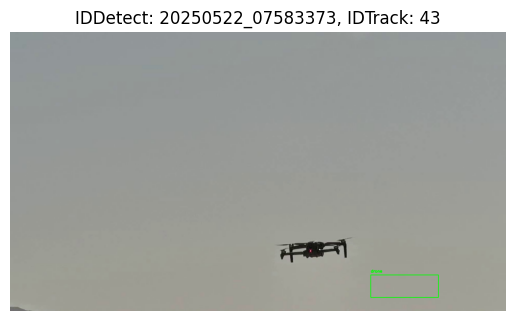

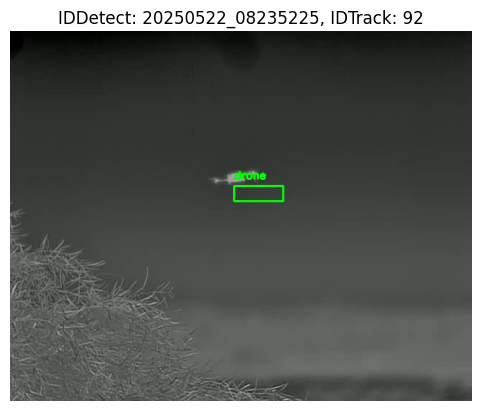

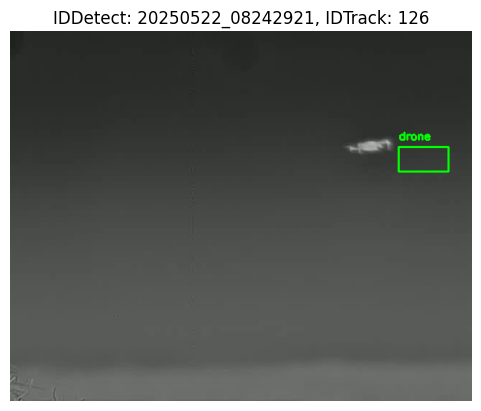

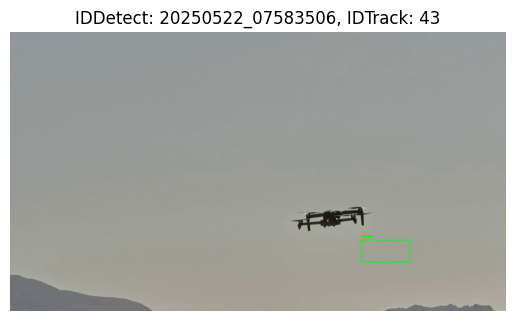

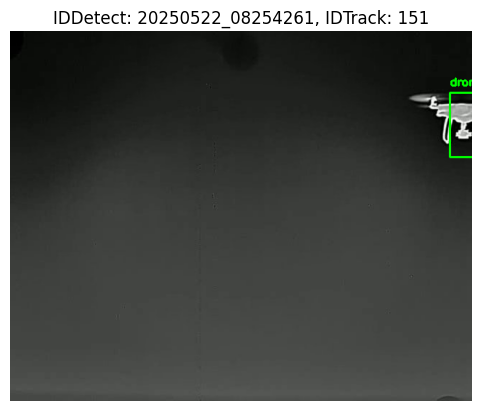

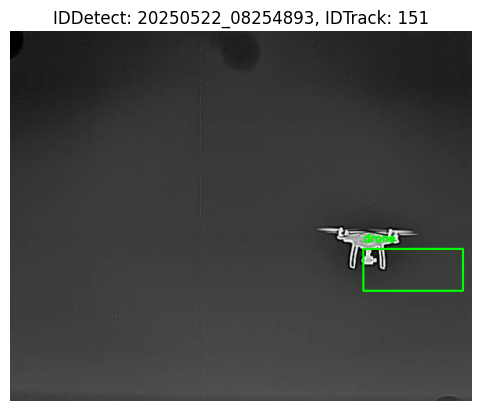

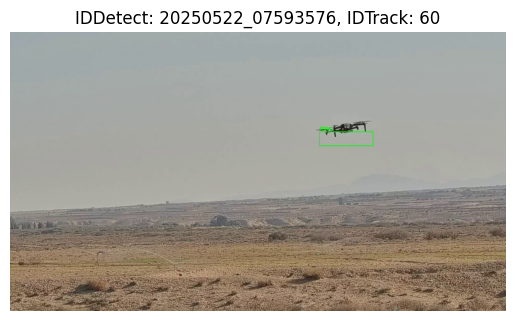

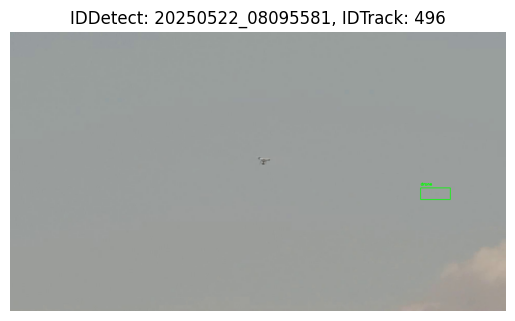

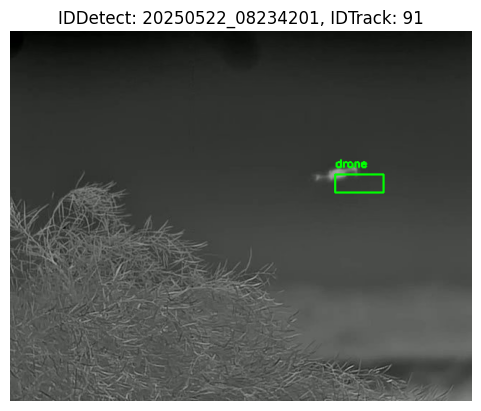

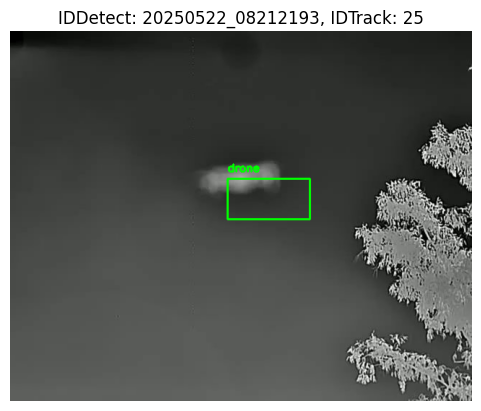

In [29]:
def parse_bbox(bbox_str):
    """Parse bbox string like '[x1,y1,x2,y2]' into tuple of ints."""
    bbox_str = bbox_str.strip().strip('[]')
    return tuple(map(int, bbox_str.split(',')))

df = pd.read_csv('output_results.csv')

for idx, row in df.iterrows():
    id_detect_val = row['id']
    
    # Find matching index in test_dataset by IDDetect
    matched_rows = [i for i, item in enumerate(train_dataset) if item['IDDetect'] == id_detect_val]
    if not matched_rows:
        print(f"No image found for IDDetect {id_detect_val}")
        continue
    img_index = matched_rows[0]
    
    pil_image = train_dataset[img_index]['image']
    image = np.array(pil_image)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    bbox = parse_bbox(row['bbox2d'])
    x1, y1, x2, y2 = bbox
    
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(image, 'drone', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX,
                0.5, (0, 255, 0), 2)
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title(f"IDDetect: {id_detect_val}, IDTrack: {row['idtrack']}")
    plt.show()

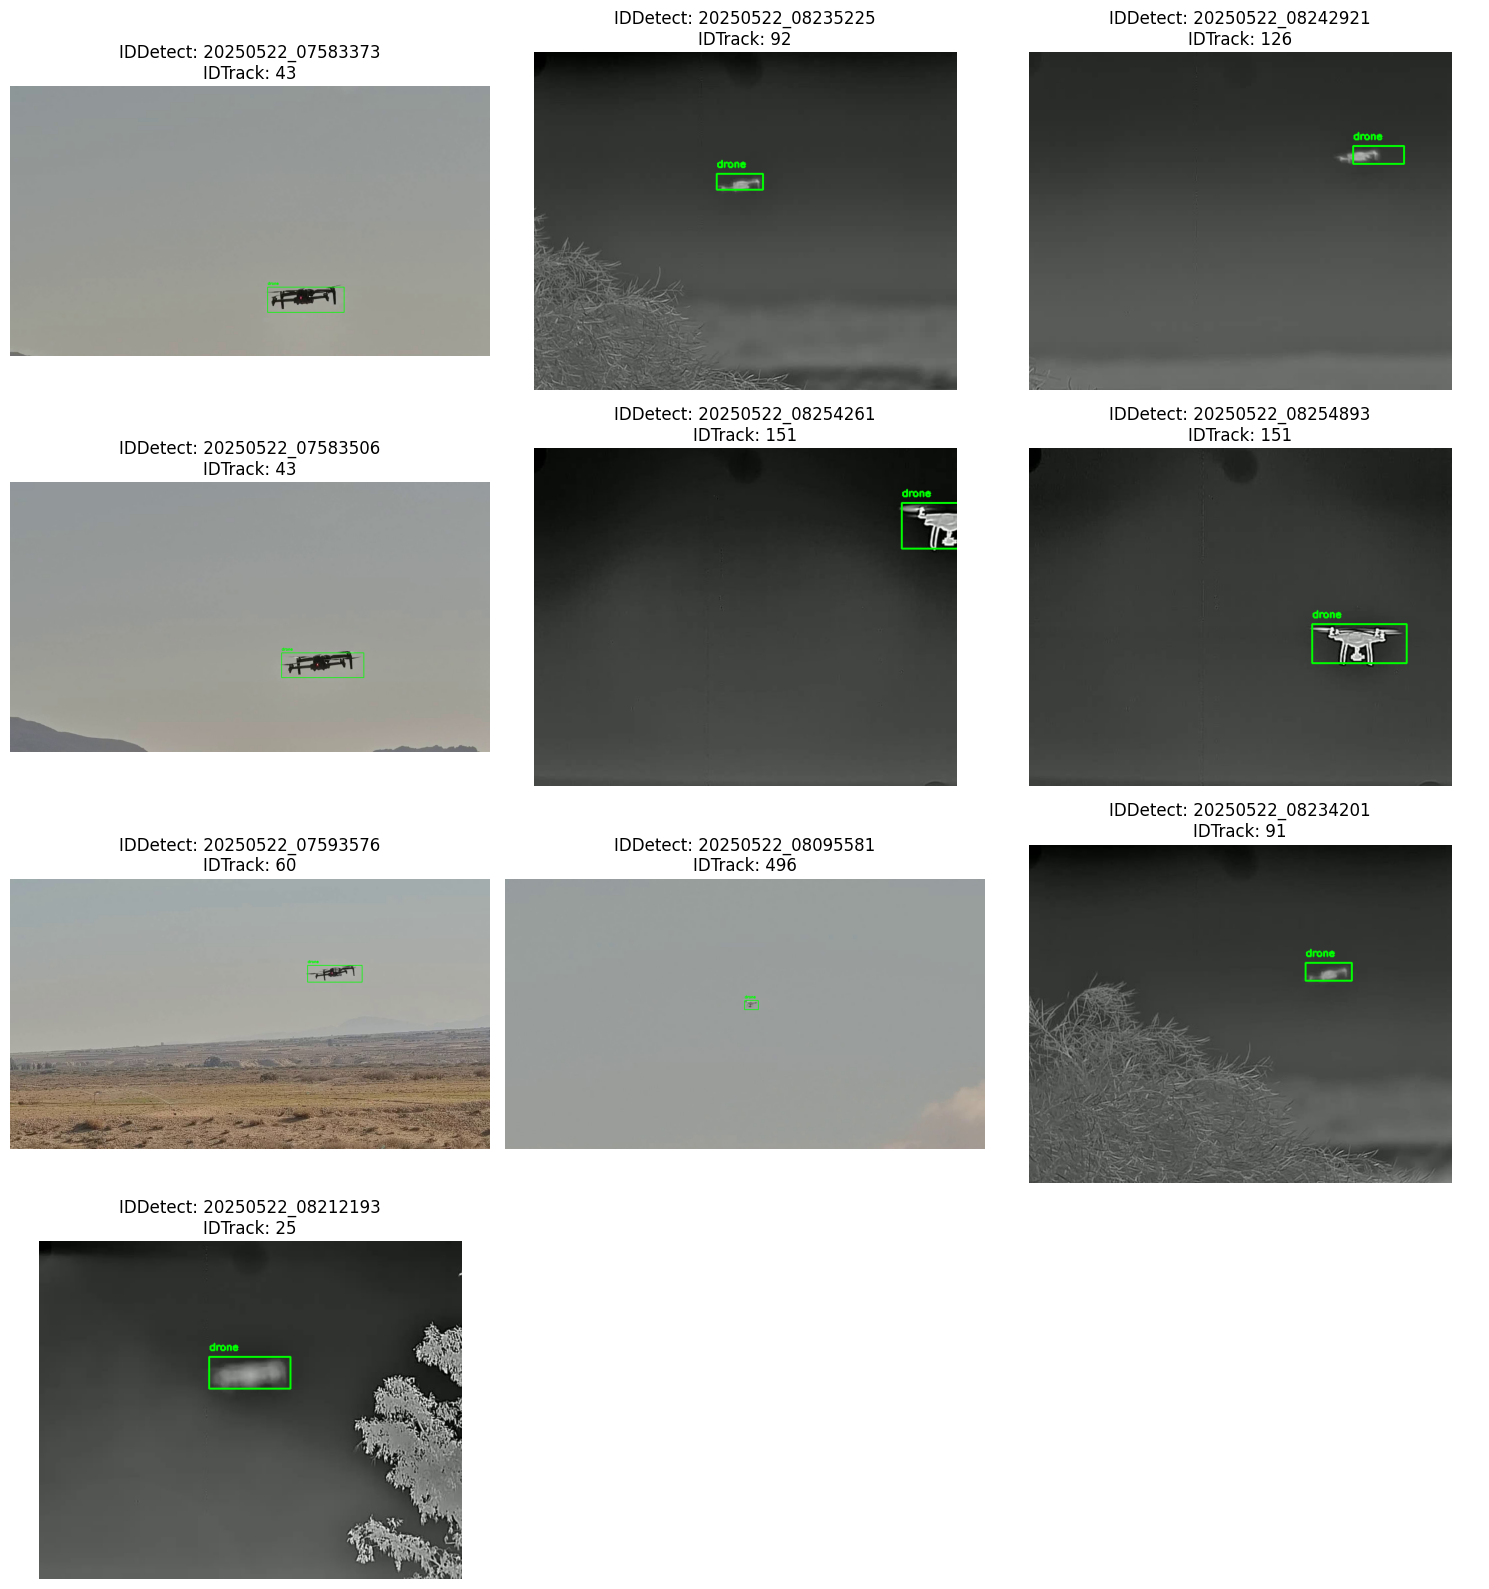

In [32]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt

def parse_bbox(bbox_str):
    bbox_str = bbox_str.strip().strip('[]')
    return tuple(map(int, bbox_str.split(',')))

df = pd.read_csv('output_results.csv')

num_images = len(df)
cols = 3  # number of columns in grid
rows = (num_images + cols - 1) // cols  # rows needed

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()  # flatten in case of 2D array

for ax in axes[num_images:]:
    ax.axis('off')  # hide unused axes if any

for idx, row in df.iterrows():
    id_detect_val = row['id']

    matched_rows = [i for i, item in enumerate(train_dataset) if item['IDDetect'] == id_detect_val]
    if not matched_rows:
        print(f"No image found for IDDetect {id_detect_val}")
        axes[idx].axis('off')
        continue
    img_index = matched_rows[0]

    pil_image = train_dataset[img_index]['image']
    image = np.array(pil_image)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    bbox = parse_bbox(row['bbox2d'])
    x1, y1, x2, y2 = bbox

    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(image, 'drone', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX,
                0.5, (0, 255, 0), 2)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    axes[idx].imshow(image_rgb)
    axes[idx].axis('off')
    axes[idx].set_title(f"IDDetect: {id_detect_val}\nIDTrack: {row['idtrack']}")

plt.tight_layout()
plt.show()
